### 퍼스널컬러 개인화 팔레트 색상 추출
    
    최초 작성일 : 20/02/23
    작성자 : 김은주
    
    작성내용 : 퍼스널컬러 타입 별 퍼스널컬러 개인화 팔레트 추출
               
               측색 결과에 따른 개인화 팔레트 추출
               -> (color_convert_test) 개인 스킨톤 HSV값
               -> HSV 분석
               -> 웜 쿨 타입 구분
                   -> 보색 이론에 따른 웜쿨타입 색상(hue) 변경값 적용
               -> 시즌 타입 구분
                   -> 각 퍼스널컬러 타입 별 명도(Value), 채도(Saturation)
               -> 개인 팔레트 색상 추출, 결과값 저장
               
               개인화 팔레트 추출 색 시각화
               
               팔레트-상품 색 매칭 & 코드추출
    
    수정내용 
        20/03/06
               개인화 팔레트 시각화
               -> 개인화 팔레트 추출 색 시각화 함수 작성
               
               팔레트-상품 색 매칭 & 코드추출
               -> 팔레트 매칭용 HSV 샘플 생성
               -> 팔레트 매칭 색 오차범위 설정
               -> HSV 오차범위 조건, fancy indexing
               -> 팔레트 매칭된 상품코드 추출
               
               팔레트 추출/시각화/상품추출 함수 통합실행으로 수정


In [4]:
# pip install colour-science
# pip install opencv-python
import pandas as pd
import numpy as np
from PIL import Image

import cv2 as cv
import colour

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\Windows/Fonts/malgun.ttf').get_name()
plt.rc('font', family=font_name)
mpl.rcParams["axes.unicode_minus"] = False
from matplotlib.colors import hsv_to_rgb

In [431]:
# 퍼스널컬러 팔레트 매칭 함수
def color_palette(person_HSV):
    # 입력값 Hue, Sturation, Value에 따라 변수 지정
    H = float(person_HSV[0])
    S = float(person_HSV[1])
    V = float(person_HSV[2])
    diff = round(V - S, 2)    
    
    # (보색, 삼각보색1, 삼각보색2, 이중보색1, 이중보색2, 이중보색3)
    # hue 변경 값
    h_warm_plus, h_cool_plus = [175, 30, 330, 50, 180, 230], [185, 150, 210, 130, 180, 310]
    # saturation 변경 값
    s_SpringWinter_plus, s_SummerAutumn_plus = [40, 10, 30, 50, 45, 50], [0, -30, -10, 10, 5, 10]
    # Value 변경 값
    v_SpringWinter_plus, v_SummerAutumn_plus = [-40, -15, -30, -40, -15, -40], [-20, 5, -10, -20, 5, -20]
    # 각 보색 값 변수
    h_list, s_list, v_list = [], [], []
    
    try:
        # 웜톤
        if H >= 26 and H <= 206 : 
            # 웜톤 HUE 변경
            for hue, i in zip(h_warm_plus, range(6)):
                if H+hue <= 359:
                    h_list.append(H+h_warm_plus[i])
                else:
                    h_list.append(H+h_warm_plus[1]-359)

            # 봄
            if diff >= 43.15 :
                for saturation, value, i in zip(s_SpringWinter_plus, v_SpringWinter_plus, range(6)):
                    # Saturation
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    # Vlaue
                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])                    

            # 가을
            elif diff <= 43.15:
                for saturation, value, i in zip(s_SummerAutumn_plus, v_SummerAutumn_plus, range(6)):
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])

                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])

        # 쿨톤
        elif (H >= 0 and H <= 25) or (H >= 207 and H <= 359) :
            # 쿨톤 HUE 변경
            for hue, i in zip(h_cool_plus, range(6)):
                if H+hue <= 359:
                    h_list.append(H+h_cool_plus[i])
                else:
                    h_list.append(H+h_cool_plus[1]-359)

            # 여름
            if diff >= 47.15 :
                for saturation, value, i in zip(s_SummerAutumn_plus, v_SummerAutumn_plus, range(6)):
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SummerAutumn_plus[i])
                        else:
                            s_list.append(S-s_SummerAutumn_plus[i])

                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SummerAutumn_plus[i])
                        else:
                            v_list.append(V-v_SummerAutumn_plus[i])

            # 겨울
            elif diff <= 47.15:
                for saturation, value, i in zip(s_SpringWinter_plus, v_SpringWinter_plus, range(6)):
                    # Saturation
                    if saturation >= 0:                    
                        if S+saturation <= 100:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    else:
                        if S+saturation >= 10:
                            s_list.append(S+s_SpringWinter_plus[i])
                        else:
                            s_list.append(S-s_SpringWinter_plus[i])
                    # Vlaue
                    if value >= 0:                    
                        if V+value <= 100:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])
                    else:
                        if V+saturation >= 10:
                            v_list.append(V+v_SpringWinter_plus[i])
                        else:
                            v_list.append(V-v_SpringWinter_plus[i])                    

        else :
            h_list, s_list, v_list = [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]
    
    except:
        print('팔레트 매칭에서 오류발생')
    
    # 팔레트 HSV
    comp_color = [h_list[0], s_list[0], v_list[0]]
    triangle_comp_color_1 = [h_list[1], s_list[1], v_list[1]]
    triangle_comp_color_2 = [h_list[2], s_list[2], v_list[2]]
    doubleness_comp_color_1 = [h_list[3], s_list[3], v_list[3]]
    doubleness_comp_color_2 = [h_list[4], s_list[4], v_list[4]]
    doubleness_comp_color_3 = [h_list[5], s_list[5], v_list[5]]
    
    personalization_palette = [comp_color, triangle_comp_color_1, triangle_comp_color_2, 
                              doubleness_comp_color_1, doubleness_comp_color_2, doubleness_comp_color_3]
    
    return personalization_palette

In [432]:
# 컬러 시각화 함수
def show_colors(personal_palette, labels):
    try:
        rows, cols, cnt = 1, len(personal_palette), 1
        fig = plt.figure(figsize=(12, 3))

        for i in range(len(personal_palette)):
            h, s, v = personal_palette[i]
            RGB = hsv_to_rgb(np.array([[[h/359, s/100, v/100]]]))

            # 시각화
            ax = fig.add_subplot(rows, cols, cnt)
            ax.imshow(RGB)
            ax.set_title(labels[i])
            ax.set_xticks([]), ax.set_yticks([])
            cnt += 1

        plt.show()
        
    except:
        print('팔레트 시각화에서 오류발생')

In [453]:
# 팔레트-상품 색 매칭 & 코드추출 테스트

############################## 색매칭용 HSV 샘플 생성
np.random.seed(0)
H = np.random.randint(0, 359, size=(70, 300))
S = np.random.randint(1, 99, size=(70, 300))
V = np.random.randint(1, 99, size=(70, 300))
CODE = np.random.randint(100000, 999999, size=(70, 300))

HSV_sample = np.dstack((H, S, V, CODE))
##############################

############################## HSV 샘플 색 시각화
# HSV_sample = np.dstack((H/359, S/100, V/100, CODE))
# RGB = hsv_to_rgb(HSV_sample[:, :, :3])

# plt.subplot(211)
# plt.imshow(RGB, origin="lower", extent=[0, 360, 0, 1], aspect=80)
# plt.xlabel("색상(Hue)")
# plt.ylabel("명도(Value)")
# plt.grid(False)

# plt.tight_layout()
# plt.show()
##############################

############################## HSV 샘플 데이터 파악
HSV_sample[:, :, 0] # H
HSV_sample[:, :, 1] # s
HSV_sample[:, :, 2] # V
HSV_sample[:, :, :3] # HSV
HSV_sample[:, :, 3] # CODE

HSV_sample[69, :, :].shape # 0~69 : (300, 4)
HSV_sample[:, 299, :].shape # 0~299 : (70, 4)
HSV_sample[:, :, 0].shape # 0~3 : (70, 300)
##############################

############################## HSV 샘플에서 색 매칭 상품코드 찾기
"""
무신사 상품이미지 측색 데이터 DB에 저장되면
나중에 
HSV_sample = np.dstack((H, S, V, CODE))
요런 형태로 끌어올 수 있게 코딩
↓↓↓↓↓아래처럼 찾아오긔↓↓↓↓↓
"""
# 오차범위 설정
### 오차범위 숫자들은 변수로 담아서 수식으로 넣기 (아래는 테스트용)
# H_idx = (HSV_sample[:, :, 0]<160)&(HSV_sample[:, :, 0]>150)
# S_idx = (HSV_sample[:, :, 1]<45)&(HSV_sample[:, :, 1]>35)
# V_idx = (HSV_sample[:, :, 2]<45)&(HSV_sample[:, :, 2]>35)

# # HSV 오차범위 조건으로 팬시인덱싱, 데이터 확인
# HSV_sample[(H_idx&S_idx&V_idx)]      # fancy indexing
# HSV_sample[(H_idx&S_idx&V_idx)][:,0] # H
# HSV_sample[(H_idx&S_idx&V_idx)][:,1] # S
# HSV_sample[(H_idx&S_idx&V_idx)][:,2] # V
# HSV_sample[(H_idx&S_idx&V_idx)][:,3] # CODE

# # fancy indexing으로 상품코드 찾기
# for i in range(HSV_sample[(H_idx&S_idx&V_idx)].shape[0]): 
#     print(i+1,"번째 매칭 상품", HSV_sample[(H_idx&S_idx&V_idx)][:,3][i])

# # np.where 로 상품코드 찾기
# for i in range(HSV_sample[(H_idx&S_idx&V_idx)].shape[0]):
#     prdt_idx1, prdt_idx2 = np.where(HSV_sample[(H_idx&S_idx&V_idx)][:,3][i] == HSV_sample[:, :, 3])
#     prdt_code = HSV_sample[:, :, 3][prdt_idx1[0], prdt_idx2[0]]
#     print("{}번째 매칭 상품 {}".format(i, prdt_code))
##############################
"희희"

'희희'

In [454]:
np.unique(CODE).shape
# CODE.reshape(1, -1).shape

(20741,)

In [457]:
# 퍼스널컬러 팔레트 추출값에 색매칭 상품코드 추출
def palette_matched_prdt(personal_palette, labels):
    try:
        show_colors(personal_palette, labels) # 팔레트 컬러 시각화 함수
        error_range = [10, 5, 5] # 색매칭 오차범위 변수담기
        matched_prdt = [] # 팔레트 총 추천상품 담을 변수

        for i in range(len(personal_palette)):
            prdt_codes = [] # 팔레트별 추출 상품코드 담을 변수
            h, s, v = personal_palette[i][0], personal_palette[i][1], personal_palette[i][2]

            # 오차범위 반영 fancy index 변수로 담기
            H_idx = (HSV_sample[:, :, 0]<(h+error_range[0]))&(HSV_sample[:, :, 0]>(h-error_range[0]))
            S_idx = (HSV_sample[:, :, 1]<(s+error_range[1]))&(HSV_sample[:, :, 1]>(s-error_range[1]))
            V_idx = (HSV_sample[:, :, 2]<(v+error_range[2]))&(HSV_sample[:, :, 2]>(v-error_range[2]))

            # fancy indexing으로 상품코드 찾기
            for j in range(HSV_sample[(H_idx&S_idx&V_idx)].shape[0]): 
                prdt_codes.append(HSV_sample[(H_idx&S_idx&V_idx)][:,3][j])

            matched_prdt.append(prdt_codes)
        
    except:
        print('상품추출에서 오류발생')
        
    return matched_prdt

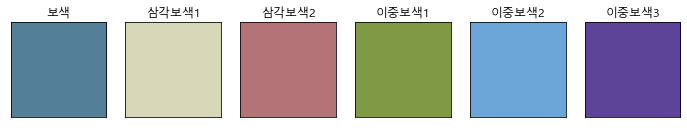

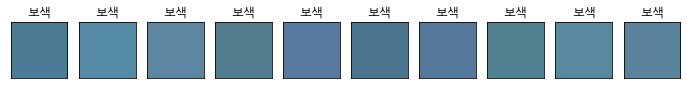

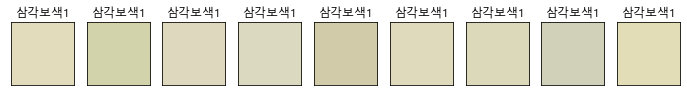

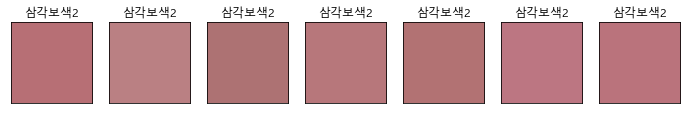

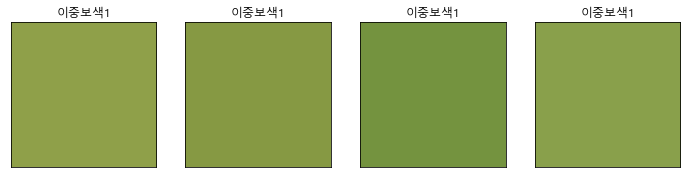

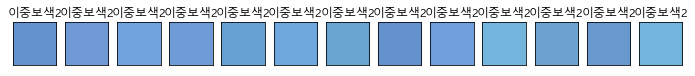

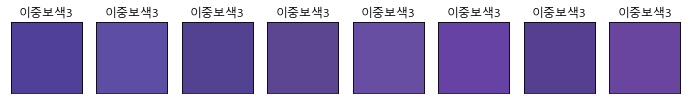

In [458]:
## 실행코드
hsv = [27, 45, 80]
labels = ["보색", "삼각보색1", "삼각보색2", "이중보색1", "이중보색2", "이중보색3"]

# 팔레트 매칭 상품추출 함수
matched_prdt = palette_matched_prdt(color_palette(hsv), labels)

## 추출된 상품 색 확인하기
for i in range(len(matched_prdt)):
    prdt_list = []
    for j in range(len(matched_prdt[i])):
        prdt = HSV_sample[matched_prdt[i][j] == HSV_sample[:, :, 3]]
        prdt_list.append([prdt[0][0], prdt[0][1], prdt[0][2]])
    show_colors(prdt_list, labels = [labels[i]]*len(prdt_list))